In [1]:
%pip install xgboost

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn.isotonic as sk_i
import seaborn as sns

# Loading the data

In [3]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
df = pd.read_pickle(PROCESSED_DIR / 'football_model_processed.pickle')
df

FileNotFoundError: [Errno 2] No such file or directory: '/data/processed/football_model_processed.pickle'

# Preparring the data

In [ ]:
# ==============================  
# SAME FEATURE SELECTION  
# ==============================
X = df.drop(columns = {'shot_outcome_encoded'})
y = df['shot_outcome_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y
)
X_train.shape, X_test.shape

((33888, 37), (11297, 37))

In [ ]:
cont_cols = [
    col for col in X_train.columns
    if pd.api.types.is_numeric_dtype(X_train[col])       # numeric
    and X_train[col].nunique() > 2              # not binary
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cont_cols] = scaler.fit_transform(X_train[cont_cols])

X_test_scaled = X_test.copy()
X_test_scaled[cont_cols] = scaler.transform(X_test[cont_cols])

# Training the model

In [ ]:
xgb_model = XGBClassifier(
    random_state=123,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist'
)

param_grid_xgb = {
    'learning_rate': [0.01, 0.05],
    'n_estimators': [600, 900],

    # Increased complexity
    'max_depth': [4, 6],
    'min_child_weight': [1, 3, 5],

    # Slightly relaxed regularization
    'gamma': [0, 2],

    # Sampling
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],

    'reg_lambda': [1, 5],
    'reg_alpha': [0, 0.3]
}


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [ ]:
print("Starting GridSearchCV training (XGBoost)...")
grid_search.fit(X_train_scaled, y_train)
print("GridSearchCV training completed.")

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)

best_model = grid_search.best_estimator_

Starting GridSearchCV training (XGBoost)...
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=600, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=600, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=600, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=600, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=600, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, g

KeyboardInterrupt: 

# Evaluate the model


Test Set Performance (XGBoost):

Test AUC: 0.8035

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10216
           1       0.69      0.10      0.17      1081

    accuracy                           0.91     11297
   macro avg       0.80      0.55      0.56     11297
weighted avg       0.89      0.91      0.88     11297


Confusion Matrix:
[[10169    47]
 [  977   104]]


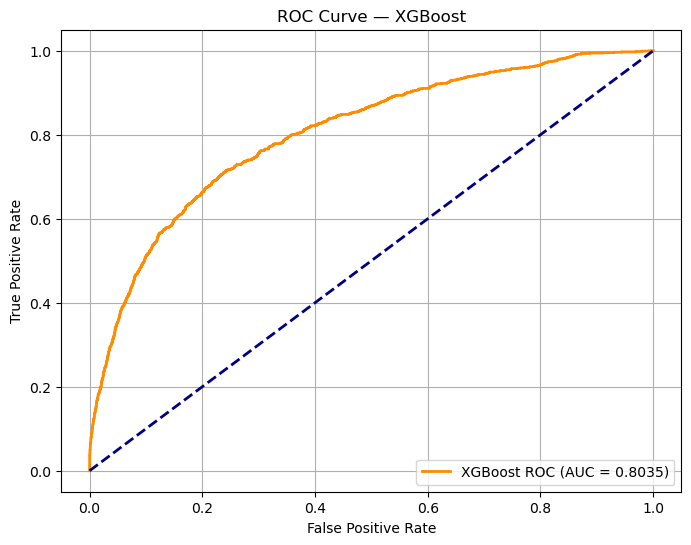

In [ ]:
print("\n" + "="*50)
print("Test Set Performance (XGBoost):")
print("="*50)

y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = best_model.predict(X_test_scaled)

test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nTest AUC: {test_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Calibration Curve

In [ ]:
evaluation = pd.DataFrame(y_test_pred_proba, y_test).reset_index()
evaluation.columns = ["outcome", "pred_prob"]

model_probs = np.linspace(0.025, 0.975, num = 20)
true_probs = []

for prob in model_probs:
    true_probs.append(evaluation[(evaluation["pred_prob"] >= prob -0.025) & (evaluation["pred_prob"] <= prob + 0.025)]["outcome"].mean())

In [ ]:
def calibration_delta(model_probs, true_probs):
    return np.sum((np.array(model_probs) - np.array(true_probs))**2)

In [ ]:
plot_probs = np.linspace(0,1.01, num = 10)

plt.plot(model_probs, true_probs, color = "red", marker='.', label = "Model line")
plt.plot(plot_probs, plot_probs, alpha = 0.5, color = "blue", label = "Ideal line")
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axvspan(0.9, 1, alpha=0.1, label = "No shots with prob > 0.9", color = "red")
plt.legend()
plt.xlabel("Model Probability")
plt.ylabel("True Probability")
plt.show()